In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# scipy.sparse import lil_matrix
# from scipy.sparse.linalg import eigsh
from typing import Tuple, List
import networkx as nx
# from IPython.display import HTML
# import matplotlib.animation as animation
from concurrent.futures import ThreadPoolExecutor

In [4]:
def triangle(coordinate: Tuple[float, float], l_side):
    vertex = [tuple(coordinate), (coordinate[0]+l_side*np.sqrt(2),coordinate[1]), (coordinate[0]+l_side/np.sqrt(2), coordinate[1]+l_side/np.sqrt(2))]
    return vertex

def rhombus(coordinate: Tuple[float, float], l_side):
    vertex = [tuple(coordinate), 
              (coordinate[0]+l_side, coordinate[1]), 
              (coordinate[0]+l_side/np.sqrt(2)+l_side,coordinate[1]+l_side/np.sqrt(2)), 
              (coordinate[0]+l_side/np.sqrt(2),coordinate[1]+l_side/np.sqrt(2))]
    return vertex

#### To exactly match the dissected tiles with the original sized tile with matched all the markings, we need to define a function to transform the tiles.
def transform_point_ini(vertices, theta, trans_x, trans_y, origin=(0,0), invert_y=False):
    # Convert tuple to list for modification
    vertices = list(vertices)
    #print(origin)
    # Translate the point to the origin
    vertices[0] -= origin[0]
    vertices[1] -= origin[1]

    # Inversion or not?
    if invert_y:
        vertices[0] = -vertices[0]

    # Rotation matrix
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotated_x = cos_theta * vertices[0] - sin_theta * vertices[1]
    rotated_y = sin_theta * vertices[0] + cos_theta * vertices[1]

    # Translate the rotated point
    translated_x = rotated_x + trans_x + origin[0]
    translated_y = rotated_y + trans_y + origin[1]
    
    return (translated_x, translated_y)

### For the transformation of the triangle
def is_inverted_tri(triangle_vertices):
    x1, y1 = triangle_vertices[0]
    x2, y2 = triangle_vertices[1]
    x3, y3 = triangle_vertices[2]

    area = 0.5 * (x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))

    return area < 0

def compute_rotation_and_scale_tri(triangle1, triangle2):
    # Check if triangle2 is inverted
    if is_inverted_tri(triangle2):
        # Invert triangle2 back
        triangle2 = [triangle2[1], triangle2[0], triangle2[2]]
    
    # Compute vectors for the sides of the triangles
    vec1_triangle1 = np.array(triangle1[1]) - np.array(triangle1[0])
    vec1_triangle2 = np.array(triangle2[1]) - np.array(triangle2[0])
    
    # Normalize the vectors
    vec1_triangle1 = vec1_triangle1 / np.linalg.norm(vec1_triangle1)
    vec1_triangle2 = vec1_triangle2 / np.linalg.norm(vec1_triangle2)
    
    # Compute the dot product and cross product of the normalized vectors
    dot_product = np.dot(vec1_triangle1, vec1_triangle2)
    cross_product = np.cross(vec1_triangle1, vec1_triangle2)
    
    # Compute the angle between the vectors using the dot and cross products
    angle = np.arctan2(cross_product, dot_product)
    
    return angle, triangle2 ## The triangle2 is reflected back if it is inverted

### For the transformation of the rhombus
def is_inverted_r(vertices):
    n = len(vertices)
    area = 0
    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        area += (x1*y2 - x2*y1)
    return area < 0

def compute_rotation_and_scale_rhombus(rhombus1, rhombus2):
    # Check if rhombus2 is inverted
    if is_inverted_r(rhombus2):
        # Invert rhombus2 back
        rhombus2 = [rhombus2[0], rhombus2[3], rhombus2[2], rhombus2[1]]
    
    # Compute vectors for the sides of the rhombuses
    vec1_rhombus1 = np.array(rhombus1[1]) - np.array(rhombus1[0])
    vec1_rhombus2 = np.array(rhombus2[1]) - np.array(rhombus2[0])
    
    # Normalize the vectors
    vec1_rhombus1 = vec1_rhombus1 / np.linalg.norm(vec1_rhombus1)
    vec1_rhombus2 = vec1_rhombus2 / np.linalg.norm(vec1_rhombus2)
    
    # Compute the dot product and cross product of the normalized vectors
    dot_product = np.dot(vec1_rhombus1, vec1_rhombus2)
    cross_product = np.cross(vec1_rhombus1, vec1_rhombus2)
    
    # Compute the angle between the vectors using the dot and cross products
    angle = np.arctan2(cross_product, dot_product)
    
    # Compute the scaling factor
    scale_factor = np.linalg.norm(np.array(rhombus2[1]) - np.array(rhombus2[0])) / np.linalg.norm(np.array(rhombus1[1]) - np.array(rhombus1[0]))
    
    return angle, scale_factor

def inflate_triangle(coordinate: Tuple[float, float], l_side)-> List[Tuple[str, List[Tuple[float, float]]]]:
    """according to arXiv:math/0203252, we dissect the triangle into 3 triangles and two rhombus with side length = l_side"""
    vertice_tri = triangle(coordinate, l_side/(1+np.sqrt(2)))
    vertice_rhom = rhombus(coordinate, l_side/(1+np.sqrt(2)))
    #vert_enlarge = [((1+np.sqrt(2))*x, (1+np.sqrt(2))*y) for x, y in vertice_tri] 
    tri1 = [transform_point_ini(i, 5*np.pi/4, l_side/(1+np.sqrt(2)), l_side/(1+np.sqrt(2)), origin=coordinate) for i in vertice_tri]
    tri2 = [transform_point_ini(x, 0, (1+np.sqrt(2))*l_side/(1+np.sqrt(2)), 0, origin=coordinate, invert_y=True) for x in vertice_tri]
    tri3 = [transform_point_ini(y, 3*np.pi/4, (2+np.sqrt(2)/2)*l_side/(1+np.sqrt(2)), (np.sqrt(2)/2)*l_side/(1+np.sqrt(2)), origin=coordinate) for y in vertice_tri]
    r1 = [transform_point_ini(i, 5*np.pi/4, (1+np.sqrt(2)/2)*l_side/(1+np.sqrt(2)), (1+np.sqrt(2)/2)*l_side/(1+np.sqrt(2)), origin=coordinate) for i in vertice_rhom]
    r2 = [transform_point_ini(x, 3*np.pi/4, (2+np.sqrt(2))*l_side/(1+np.sqrt(2)), 0, origin=coordinate) for x in vertice_rhom]
    return [[tri1], [tri2], [tri3], [r1] ,[r2]]

def inflate_rhombus(coordinate: Tuple[float, float], l_side) -> List[Tuple[str, List[Tuple[float, float]]]]:
    """according to arXiv:math/0203252, we dissect the rhombus into 4 triangles and 3 rhombus with side length = l_side"""
    vertice_tri = triangle(coordinate, l_side/(1+np.sqrt(2)))
    vertice_rhom = rhombus(coordinate, l_side/(1+np.sqrt(2)))
    tri1 = [transform_point_ini(i, 0, l_side/(1+np.sqrt(2)), 0) for i in vertice_tri]
    tri2 = [transform_point_ini(i, np.pi, (1+3*np.sqrt(2)/2)*l_side/(1+np.sqrt(2)), (1+np.sqrt(2)/2)*l_side/(1+np.sqrt(2)), origin=coordinate) for i in vertice_tri]
    tri3 = [transform_point_ini(i, np.pi/4, (2+np.sqrt(2))*l_side/(1+np.sqrt(2)), l_side/(1+np.sqrt(2)), origin=coordinate, invert_y=True) for i in vertice_tri]
    tri4 = [transform_point_ini(i, 5*np.pi/4, (np.sqrt(2)/2)*l_side/(1+np.sqrt(2)), (np.sqrt(2)/2)*l_side/(1+np.sqrt(2)), origin=coordinate, invert_y=True) for i in vertice_tri]
    r1 = [transform_point_ini(i, 0, 0, 0, origin=coordinate) for i in vertice_rhom]
    r2 = [transform_point_ini(i, np.pi/2, (1+np.sqrt(2))*l_side/(1+np.sqrt(2)), 0, origin=coordinate) for i in vertice_rhom]
    r3 = [transform_point_ini(i, 0, (1+np.sqrt(2))*l_side/(1+np.sqrt(2)), l_side/(1+np.sqrt(2)), origin=coordinate) for i in vertice_rhom]
    return [[tri1], [tri2], [tri3], [tri4], [r1], [r2], [r3]]

def transform_point(vertices, theta, trans_x, trans_y, origin=(0,0), invert_y=False):
    # Convert tuple to list for modification
    vertices = list(vertices)
    #print(origin)
    # Translate the point to the origin
    #vertices[0] -= origin[0]
    #vertices[1] -= origin[1]

    # Inversion or not?
    if invert_y:
        vertices[0] = -vertices[0]

    # Rotation matrix
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotated_x = cos_theta * vertices[0] - sin_theta * vertices[1]
    rotated_y = sin_theta * vertices[0] + cos_theta * vertices[1]

    # Translate the rotated point
    translated_x = rotated_x + trans_x + origin[0]
    translated_y = rotated_y + trans_y + origin[1]
    
    return (translated_x, translated_y)

def reverse_transform_point(vertices, theta, trans_x, trans_y, origin=(0,0), invert_y=False):
    '''The reverse of the transform_point function. 
    It is used to find the original position of the tile before transformation.'''
    # Convert tuple to list for modification
    vertices = list(vertices)
    #print(vertices)
    #print(origin)
    # Translate the point to the origin
    vertices[0] -= origin[0]
    vertices[1] -= origin[1]

    # Reverse the translation
    vertices[0] -= trans_x
    vertices[1] -= trans_y
    #print(vertices)
    # Reverse the rotation
    cos_theta = np.cos(-theta)
    sin_theta = np.sin(-theta)
    rotated_x = cos_theta * vertices[0] - sin_theta * vertices[1]
    rotated_y = sin_theta * vertices[0] + cos_theta * vertices[1]

    # Inversion or not?
    if invert_y:
        rotated_x = -rotated_x

    # Translate back to the original position
    #translated_x = rotated_x + origin[0]
    translated_x = rotated_x
    #translated_y = rotated_y + origin[1]
    translated_y = rotated_y
    
    return (translated_x, translated_y)

def plot_shapes(shapes, title):
    """
    Plots a list of shapes using matplotlib.
    
    Args:
    - shapes (list): A list of shapes, where each shape is a list of (x, y) coordinates.
    - title (str): The title of the plot.
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    
    for shape in shapes:
        polygon = patches.Polygon(shape, closed=True, fill=None, edgecolor='r')
        ax.add_patch(polygon)
    
    ax.set_aspect('equal')
    ax.autoscale_view()
    plt.show()

In [2]:
def find_closest_vertex_to_origin(vertices):
    distances = [np.sqrt(x**2 + y**2) for x, y in vertices]
    min_index = distances.index(min(distances))
    return vertices[min_index]

In [3]:
r = [[(1, 1), (2, 1), (3/2, 3/2)]]
[find_closest_vertex_to_origin(i) for i in r]

[(1, 1)]

In [5]:
def inflate_triangle_iterate_final(tile, ls_initial, number_iterate, initial_position) -> List[List[Tuple[float, float]]]:
    kk = 0
    vertice_tri = triangle((0,0), ls_initial/(1+np.sqrt(2)))
    vertice_rhom = rhombus((0,0), ls_initial/(1+np.sqrt(2)))
    
    while kk < number_iterate:
        kk += 1
        
        if isinstance(tile[0], tuple):
            tile = [tile]
        
        # Translate the vertices to the origin before scaling
        inflate_shapes = [([(x-initial_position[0], y-initial_position[1]) for x, y in vertices]) for vertices in tile]
        inflate_shapes = [([(x*(1+np.sqrt(2))*ls_initial, y*(1+np.sqrt(2))*ls_initial) for x, y in vertices]) for vertices in inflate_shapes]
        all_tiles = []

        for i, j in enumerate(inflate_shapes):
            if len(j) == 3:
                angletri, triangle_c = compute_rotation_and_scale_tri(vertice_tri, j)
                newtri = [reverse_transform_point(p, angletri, 0, 0, triangle_c[0]) for p in j]
                if is_inverted_tri(j):
                    inflatetri = inflate_triangle(newtri[1], ls_initial)
                else:
                    inflatetri = inflate_triangle(newtri[0], ls_initial)
                    
                inflatetri_shapes = [shape[0] for shape in inflatetri]
                if is_inverted_tri(j):
                    inflatetri1 = [[transform_point(p, angletri, 0, 0, j[0], True) for p in shape] for shape in inflatetri_shapes]
                else:
                    inflatetri1 = [[transform_point(p, angletri, 0, 0, j[0]) for p in shape] for shape in inflatetri_shapes]
                
                # Translate the inflated shapes back to the initial position
                inflatetri1 = [[(x+initial_position[0], y+initial_position[1]) for x, y in shape] for shape in inflatetri1]
                
                all_tiles.extend(inflatetri1)
            elif len(j) == 4:
                angler, _ = compute_rotation_and_scale_rhombus(vertice_rhom, j)
                newr = [reverse_transform_point(p, angler, 0, 0, j[0]) for p in j]
                
                inflater = inflate_rhombus(newr[0], ls_initial)
                inflater_shapes = [shape[0] for shape in inflater]
                
                inflater1 = [[transform_point(p, angler, 0, 0, j[0]) for p in shape] for shape in inflater_shapes]
                
                # Translate the inflated shapes back to the initial position
                inflater1 = [[(x+initial_position[0], y+initial_position[1]) for x, y in shape] for shape in inflater1]
                
                all_tiles.extend(inflater1)
        
        plot_shapes(all_tiles, f"All tiles after iteration {kk}")
        tile = all_tiles
    
    return all_tiles

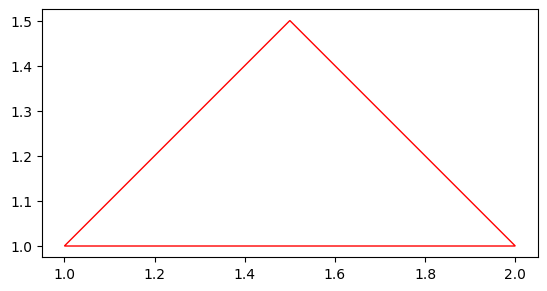

In [8]:
plot_shapes(r,None)

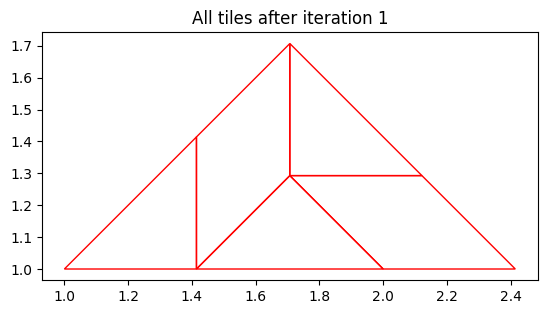

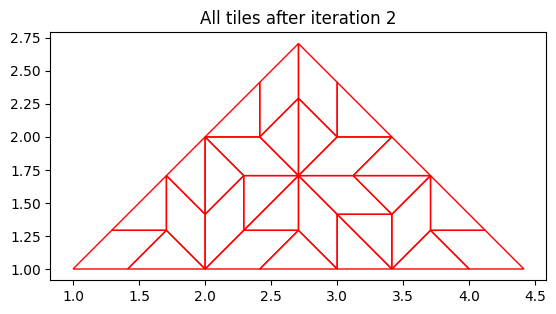

[[(2.0, 1.4142135623730954),
  (2.0000000000000004, 2.0000000000000004),
  (1.7071067811865477, 1.707106781186548)],
 [(1.2928932188134525, 1.292893218813453),
  (1.7071067811865477, 1.707106781186548),
  (1.7071067811865475, 1.292893218813453)],
 [(1.414213562373095, 1.0000000000000004),
  (2.0, 1.0000000000000002),
  (1.7071067811865475, 1.2928932188134528)],
 [(1.9999999999999998, 1.0000000000000002),
  (2.0, 1.4142135623730954),
  (1.7071067811865477, 1.707106781186548),
  (1.7071067811865475, 1.292893218813453)],
 [(0.9999999999999998, 1.0000000000000004),
  (1.414213562373095, 1.0000000000000004),
  (1.7071067811865475, 1.2928932188134528),
  (1.2928932188134525, 1.292893218813453)],
 [(3.0, 1.4142135623730951), (3.414213562373095, 1.0), (3.0, 1.0)],
 [(2.414213562373095, 1.0),
  (3.0, 1.0),
  (2.7071067811865475, 1.2928932188134525)],
 [(2.292893218813452, 1.2928932188134525),
  (2.7071067811865475, 1.7071067811865477),
  (2.7071067811865475, 1.2928932188134525)],
 [(2.707106781

In [7]:
inflate_triangle_iterate_final([[(1, 1), (2, 1), (3/2, 3/2)]], 1, 2, (1, 1))

In [77]:
def inflate_triangle_iterate_final(tile, ls_initial, number_iterate) -> List[List[Tuple[float, float]]]:
    kk = 0
    vertice_tri = triangle((0,0), ls_initial/(1+np.sqrt(2)))
    vertice_rhom = rhombus((0,0), ls_initial/(1+np.sqrt(2)))
    initial_position = [find_closest_vertex_to_origin(vertices) for vertices in tile]
    print("ini",initial_position)
    while kk < number_iterate:
        kk += 1
        
        if isinstance(tile[0], tuple):
            tile = [tile]
        
        # Translate the vertices to the origin before scaling
        inflate_shapes = [([(x-initial_position[0][0], y-initial_position[0][1]) for x, y in vertices]) for vertices in tile]
        inflate_shapes = [([(x*(1+np.sqrt(2))*ls_initial, y*(1+np.sqrt(2))*ls_initial) for x, y in vertices]) for vertices in inflate_shapes]
        all_tiles = []

        for i, j in enumerate(inflate_shapes):
            if len(j) == 3:
                angletri, triangle_c = compute_rotation_and_scale_tri(vertice_tri, j)
                newtri = [reverse_transform_point(p, angletri, 0, 0, triangle_c[0]) for p in j]
                if is_inverted_tri(j):
                    inflatetri = inflate_triangle(newtri[1], ls_initial)
                else:
                    inflatetri = inflate_triangle(newtri[0], ls_initial)
                    
                inflatetri_shapes = [shape[0] for shape in inflatetri]
                if is_inverted_tri(j):
                    inflatetri1 = [[transform_point(p, angletri, 0, 0, j[0], True) for p in shape] for shape in inflatetri_shapes]
                else:
                    inflatetri1 = [[transform_point(p, angletri, 0, 0, j[0]) for p in shape] for shape in inflatetri_shapes]
                
                # Translate the inflated shapes back to the initial position
                inflatetri1 = [[(x+initial_position[0][0], y+initial_position[0][1]) for x, y in shape] for shape in inflatetri1]
                
                all_tiles.extend(inflatetri1)
            elif len(j) == 4:
                angler, _ = compute_rotation_and_scale_rhombus(vertice_rhom, j)
                newr = [reverse_transform_point(p, angler, 0, 0, j[0]) for p in j]
                
                inflater = inflate_rhombus(newr[0], ls_initial)
                inflater_shapes = [shape[0] for shape in inflater]
                
                inflater1 = [[transform_point(p, angler, 0, 0, j[0]) for p in shape] for shape in inflater_shapes]
                
                # Translate the inflated shapes back to the initial position
                inflater1 = [[(x+initial_position[0][0], y+initial_position[0][1]) for x, y in shape] for shape in inflater1]
                
                all_tiles.extend(inflater1)
        
        plot_shapes(all_tiles, f"All tiles after iteration {kk}")
        tile = all_tiles
    
    return all_tiles

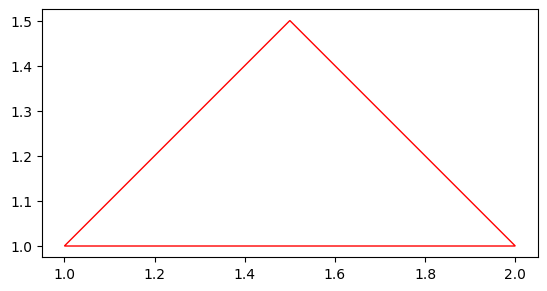

In [78]:
plot_shapes([[(1, 1), (2, 1), (3/2, 3/2)]],None)

ini [(1, 1)]


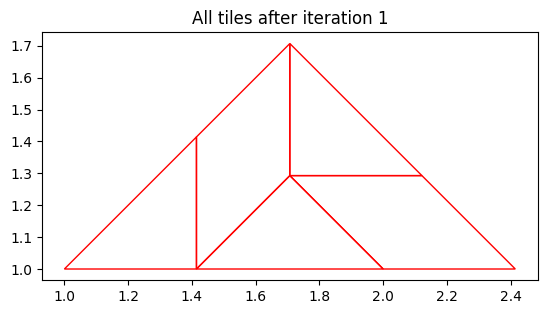

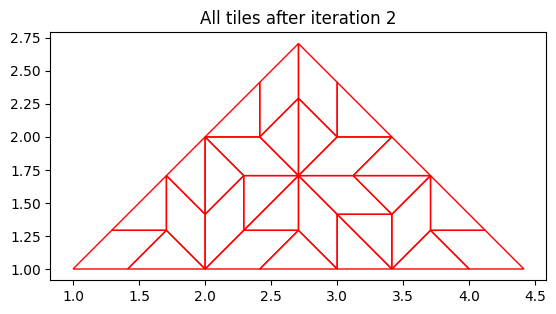

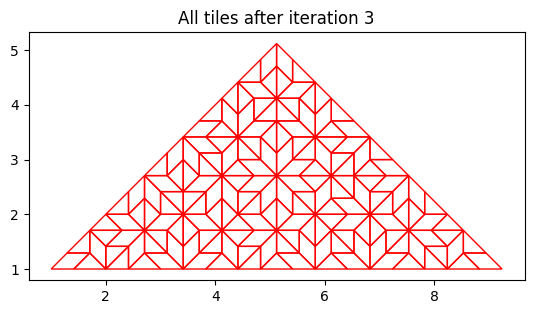

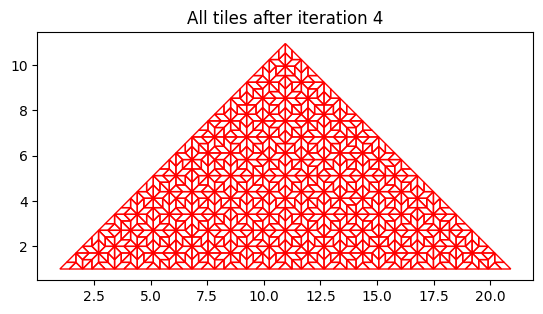

In [79]:
all = inflate_triangle_iterate_final([[(1, 1), (2, 1), (3/2, 3/2)]], 1, 4)

In [73]:
def find_points_below(points, threshold):
    below_points = []
    for shape in points:
        for point in shape:
            if point[1] < threshold[1] and point[0] < threshold[0]:
                below_points.append(point)
    return below_points

# Example usage
threshold = (1.1, 1.1)
points_below = find_points_below(all, threshold)

print("Points below", threshold, ":")
for point in points_below:
    print(point)

Points below (1.1, 1.1) :
(0.9999999999999987, 1.0000000000000027)


In [68]:
a = 1/np.sqrt(2)
r8 = [(0, 0), (0, 1), (-a, 1+a), (-a, a)]
r9 = [(-1-a, 1+a), (-a, 1+a), (0, 1+1/a), (-1, 1+1/a)]

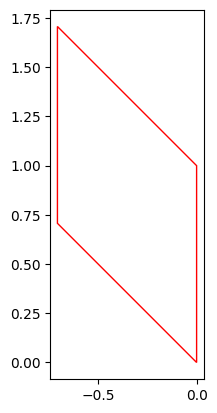

[(0, 0), (0, 1), (-0.7071067811865475, 1.7071067811865475), (-0.7071067811865475, 0.7071067811865475)]


In [69]:
plot_shapes([r8], None)
print(r8)

ini [(0, 0)]


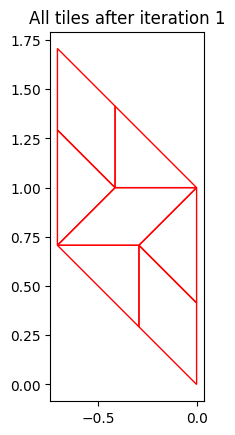

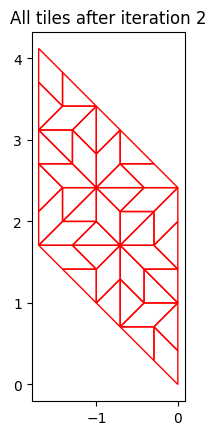

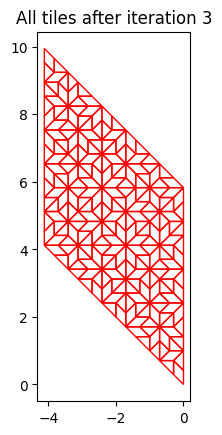

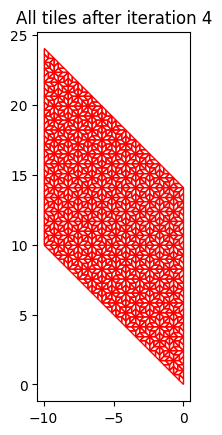

In [70]:
tile = inflate_triangle_iterate_final([r8], 1, 4)

In [81]:
def inflate_triangle_iterate_final(tiles, ls_initial, number_iterate) -> List[List[Tuple[float, float]]]:
    kk = 0
    vertice_tri = triangle((0,0), ls_initial/(1+np.sqrt(2)))
    vertice_rhom = rhombus((0,0), ls_initial/(1+np.sqrt(2)))
    
    initial_positions = [find_closest_vertex_to_origin(tile) for tile in tiles]
    print(initial_positions)
    while kk < number_iterate:
        kk += 1
        
        all_tiles = []

        for tile, initial_position in zip(tiles, initial_positions):
            if isinstance(tile[0], tuple):
                tile = [tile]
            
            # Translate the vertices to the origin before scaling
            inflate_shapes = [([(x-initial_position[0], y-initial_position[1]) for x, y in vertices]) for vertices in tile]
            inflate_shapes = [([(x*(1+np.sqrt(2))*ls_initial, y*(1+np.sqrt(2))*ls_initial) for x, y in vertices]) for vertices in inflate_shapes]
            
            for i, j in enumerate(inflate_shapes):
                if len(j) == 3:
                    angletri, triangle_c = compute_rotation_and_scale_tri(vertice_tri, j)
                    newtri = [reverse_transform_point(p, angletri, 0, 0, triangle_c[0]) for p in j]
                    if is_inverted_tri(j):
                        inflatetri = inflate_triangle(newtri[1], ls_initial)
                    else:
                        inflatetri = inflate_triangle(newtri[0], ls_initial)
                        
                    inflatetri_shapes = [shape[0] for shape in inflatetri]
                    if is_inverted_tri(j):
                        inflatetri1 = [[transform_point(p, angletri, 0, 0, j[0], True) for p in shape] for shape in inflatetri_shapes]
                    else:
                        inflatetri1 = [[transform_point(p, angletri, 0, 0, j[0]) for p in shape] for shape in inflatetri_shapes]
                    
                    # Translate the inflated shapes back to the initial position
                    inflatetri1 = [[(x+initial_position[0], y+initial_position[1]) for x, y in shape] for shape in inflatetri1]
                    
                    all_tiles.extend(inflatetri1)
                elif len(j) == 4:
                    angler, _ = compute_rotation_and_scale_rhombus(vertice_rhom, j)
                    newr = [reverse_transform_point(p, angler, 0, 0, j[0]) for p in j]
                    
                    inflater = inflate_rhombus(newr[0], ls_initial)
                    inflater_shapes = [shape[0] for shape in inflater]
                    
                    inflater1 = [[transform_point(p, angler, 0, 0, j[0]) for p in shape] for shape in inflater_shapes]
                    
                    # Translate the inflated shapes back to the initial position
                    inflater1 = [[(x+initial_position[0], y+initial_position[1]) for x, y in shape] for shape in inflater1]
                    
                    all_tiles.extend(inflater1)
        
        plot_shapes(all_tiles, f"All tiles after iteration {kk}")
        tiles = all_tiles
    
    return all_tiles

In [82]:
t1 = [(0, 1), (0, 1+1/a), (a, 1+a)]
t2 = [(a, a), (1+a, 1+a), (a, 1+a)]
t3 = [(a, a), (1+a, 1+a), (1+a, a)]
t4 = [(1, 0), (1+1/a, 0), (1+a, a)]
t5 = [(1, 0), (1+1/a, 0), (1+a, -a)]
t6 = [(a, -a), (1+a, -1-a), (1+a, -a)]
t7 = [(a, -a), (1+a, -1-a), (a, -1-a)]
t8 = [(0, -1), (0, -1-1/a), (a, -1-a)]
t9 = [(0, -1), (0, -1-1/a), (-a, -1-a)]
t10 = [(-a, -a), (-1-a, -1-a), (-a, -1-a)]
t11 = [(-a, -a), (-1-a, -1-a), (-1-a, -a)]
t12 = [(-1, 0), (-1-1/a, 0), (-1-a, -a)]
t13 = [(-1, 0), (-1-1/a, 0), (-1-a, a)]
t14 = [(-a, a), (-1-a, 1+a), (-1-a, a)]
t15 = [(-a, a), (-1-a, 1+a), (-a, 1+a)]
t16 = [(0, 1), (0, 1+1/a), (-a, 1+a)]

In [83]:
# Initialize the larger list
larger_t = []

# append the larger list with each smaller list
larger_t.append(t1)
larger_t.append(t2)
larger_t.append(t3)
larger_t.append(t4)
larger_t.append(t5)
larger_t.append(t6)
larger_t.append(t7)
larger_t.append(t8)
larger_t.append(t9)
larger_t.append(t10)
larger_t.append(t11)
larger_t.append(t12)
larger_t.append(t13)
larger_t.append(t14)
larger_t.append(t15)
larger_t.append(t16)

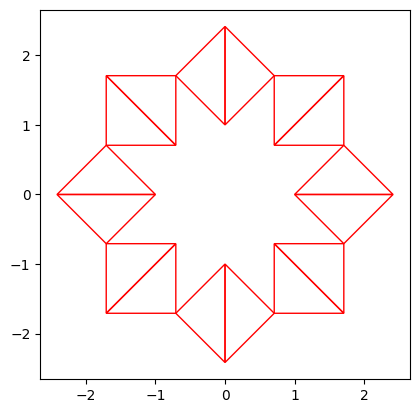

In [84]:
plot_t = plot_shapes(larger_t, None)

[(0, 1), (0.7071067811865475, 0.7071067811865475), (0.7071067811865475, 0.7071067811865475), (1, 0), (1, 0), (0.7071067811865475, -0.7071067811865475), (0.7071067811865475, -0.7071067811865475), (0, -1), (0, -1), (-0.7071067811865475, -0.7071067811865475), (-0.7071067811865475, -0.7071067811865475), (-1, 0), (-1, 0), (-0.7071067811865475, 0.7071067811865475), (-0.7071067811865475, 0.7071067811865475), (0, 1)]


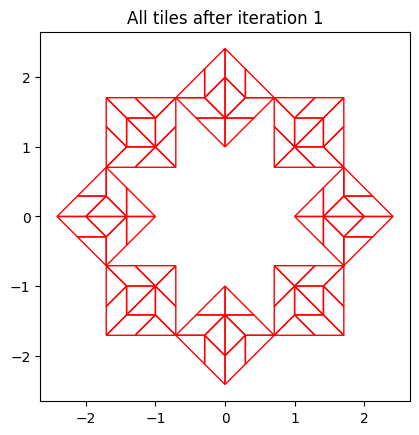

In [85]:
ver = inflate_triangle_iterate_final(larger_t, 1, 1)

In [87]:
def inflate_triangle_iterate_final(tiles, ls_initial, number_iterate) -> List[List[Tuple[float, float]]]:
    kk = 0
    vertice_tri = triangle((0,0), ls_initial/(1+np.sqrt(2)))
    vertice_rhom = rhombus((0,0), ls_initial/(1+np.sqrt(2)))
    
    while kk < number_iterate:
        kk += 1
        all_tiles = []

        if kk == 1:
            initial_positions = [find_closest_vertex_to_origin(tile) for tile in tiles]
        else:
            initial_positions = [find_closest_vertex_to_origin(tile) for tile in tiles]

        for tile, initial_position in zip(tiles, initial_positions):
            if isinstance(tile[0], tuple):
                tile = [tile]
            
            # Translate the vertices to the origin before scaling
            inflate_shapes = [([(x-initial_position[0], y-initial_position[1]) for x, y in vertices]) for vertices in tile]
            inflate_shapes = [([(x*(1+np.sqrt(2))*ls_initial, y*(1+np.sqrt(2))*ls_initial) for x, y in vertices]) for vertices in inflate_shapes]
            
            for i, j in enumerate(inflate_shapes):
                if len(j) == 3:
                    angletri, triangle_c = compute_rotation_and_scale_tri(vertice_tri, j)
                    newtri = [reverse_transform_point(p, angletri, 0, 0, triangle_c[0]) for p in j]
                    if is_inverted_tri(j):
                        inflatetri = inflate_triangle(newtri[1], ls_initial)
                    else:
                        inflatetri = inflate_triangle(newtri[0], ls_initial)
                        
                    inflatetri_shapes = [shape[0] for shape in inflatetri]
                    if is_inverted_tri(j):
                        inflatetri1 = [[transform_point(p, angletri, 0, 0, j[0], True) for p in shape] for shape in inflatetri_shapes]
                    else:
                        inflatetri1 = [[transform_point(p, angletri, 0, 0, j[0]) for p in shape] for shape in inflatetri_shapes]
                    
                    # Translate the inflated shapes back to the initial position
                    inflatetri1 = [[(x+initial_position[0], y+initial_position[1]) for x, y in shape] for shape in inflatetri1]
                    
                    all_tiles.extend(inflatetri1)
                elif len(j) == 4:
                    angler, _ = compute_rotation_and_scale_rhombus(vertice_rhom, j)
                    newr = [reverse_transform_point(p, angler, 0, 0, j[0]) for p in j]
                    
                    inflater = inflate_rhombus(newr[0], ls_initial)
                    inflater_shapes = [shape[0] for shape in inflater]
                    
                    inflater1 = [[transform_point(p, angler, 0, 0, j[0]) for p in shape] for shape in inflater_shapes]
                    
                    # Translate the inflated shapes back to the initial position
                    inflater1 = [[(x+initial_position[0], y+initial_position[1]) for x, y in shape] for shape in inflater1]
                    
                    all_tiles.extend(inflater1)
        
        plot_shapes(all_tiles, f"All tiles after iteration {kk}")
        tiles = all_tiles
    
    return all_tiles

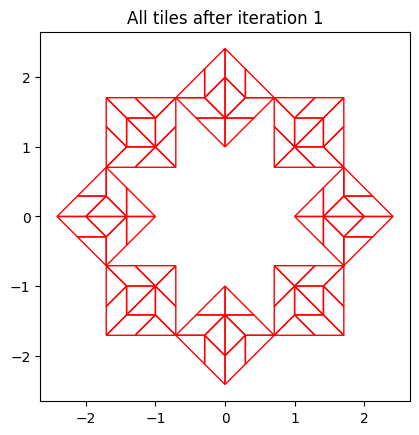

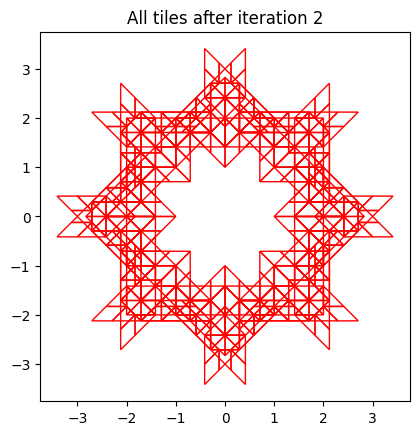

In [89]:
ver = inflate_triangle_iterate_final(larger_t, 1, 2)

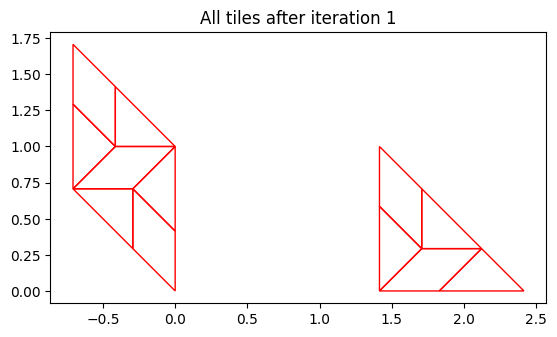

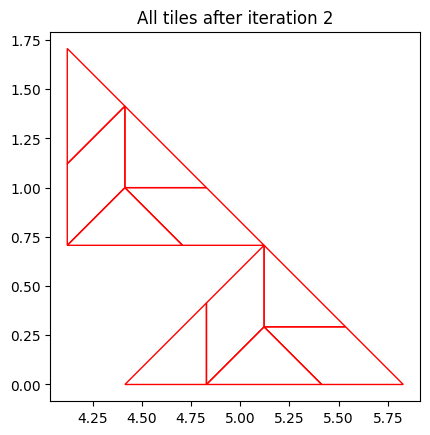

[[(4.828427124746189, 0.4142135623730951),
  (4.414213562373094, 1.3401577416544662e-16),
  (4.828427124746189, 1.1496735851465533e-17)],
 [(5.414213562373094, -1.6177134978107534e-16),
  (4.828427124746189, 1.1496735851465558e-17),
  (5.121320343559642, 0.29289321881345237)],
 [(5.535533905932737, 0.2928932188134523),
  (5.121320343559642, 0.7071067811865476),
  (5.121320343559642, 0.2928932188134524)],
 [(5.121320343559642, 0.7071067811865475),
  (4.828427124746189, 0.4142135623730951),
  (4.828427124746189, 1.1496735851465533e-17),
  (5.121320343559642, 0.29289321881345237)],
 [(5.828427124746189, -2.8429038809505643e-16),
  (5.535533905932737, 0.2928932188134523),
  (5.121320343559642, 0.2928932188134525),
  (5.414213562373094, -1.3401577416544643e-16)],
 [(4.121320343559642, 1.1213203435596424),
  (4.121320343559642, 1.7071067811865477),
  (4.414213562373094, 1.414213562373095)],
 [(4.82842712474619, 0.9999999999999999),
  (4.414213562373094, 1.414213562373095),
  (4.4142135623730

In [92]:
r8 = [(0, 0), (0, 1), (-a, 1+a), (-a, a)]
tri = [(1, 0), (0, 1), (0,0)]
aa = [tri, r8]
inflate_triangle_iterate_final(aa, 1, 2)

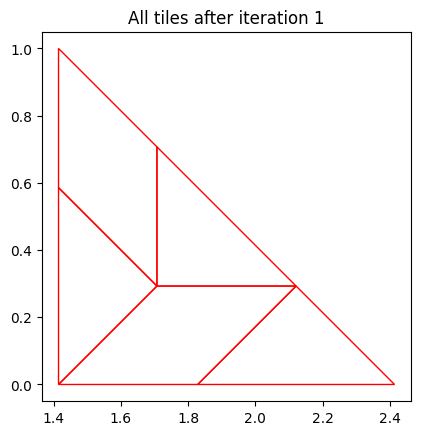

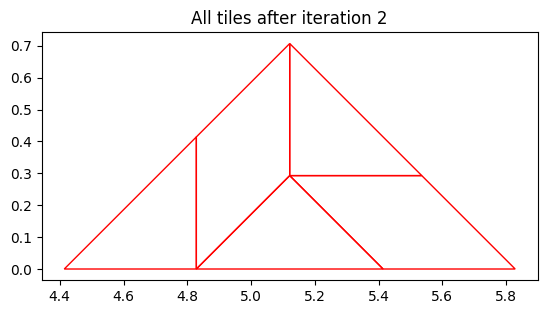

[[(4.828427124746189, 0.4142135623730951),
  (4.414213562373094, 1.3401577416544662e-16),
  (4.828427124746189, 1.1496735851465533e-17)],
 [(5.414213562373094, -1.6177134978107534e-16),
  (4.828427124746189, 1.1496735851465558e-17),
  (5.121320343559642, 0.29289321881345237)],
 [(5.535533905932737, 0.2928932188134523),
  (5.121320343559642, 0.7071067811865476),
  (5.121320343559642, 0.2928932188134524)],
 [(5.121320343559642, 0.7071067811865475),
  (4.828427124746189, 0.4142135623730951),
  (4.828427124746189, 1.1496735851465533e-17),
  (5.121320343559642, 0.29289321881345237)],
 [(5.828427124746189, -2.8429038809505643e-16),
  (5.535533905932737, 0.2928932188134523),
  (5.121320343559642, 0.2928932188134525),
  (5.414213562373094, -1.3401577416544643e-16)]]

In [94]:
inflate_triangle_iterate_final([tri], 1, 2)